https://openturns.github.io/openturns/latest/usecases/use_case_wingweight.html

In [1]:
import openturns as ot
import numpy as np
from openturns.usecases import wingweight_function
import openturns.viewer as viewer

In [2]:
ww = wingweight_function.WingWeightModel()
distribution_entrees = ww.distributionX
model_masse = ww.model

formule = '0.036*Sw^0.758*Wfw^0.0035*(A/cos(Lambda)^2)^0.6*q^0.006*l^0.04*(100*tc/cos(Lambda))^(-0.3)*(Nz*Wdg)^0.49 + Sw*Wp'
g = ot.SymbolicFunction(distribution_entrees.getDescription(), [formule])

In [3]:
#model_masse est une fonction python et g une fonction symbolique

moyenne_entrees = distribution_entrees.getMean()
print('gradient g : ', g.gradient(moyenne_entrees))
print('gradient model_masse : ', model_masse.gradient(moyenne_entrees))
grad = g.gradient(moyenne_entrees)
#print("Erreurs relatives par composante=", [abs(1-grad[i, 0] / grad[i, 0]) for i in range(len(moyenne_entrees))])

gradient g :  10x1
[[    1.1719     ]
 [    0.00347896 ]
 [   19.3828     ]
 [    0          ]
 [    0.0508401  ]
 [   13.7833     ]
 [ -596.394      ]
 [   29.7963     ]
 [    0.060302   ]
 [  175          ]]
gradient model_masse :  10x1
[[    1.1719     ]
 [    0.00347896 ]
 [   19.3828     ]
 [    0          ]
 [    0.0508401  ]
 [   13.7833     ]
 [ -596.394      ]
 [   29.7963     ]
 [    0.060302   ]
 [  175          ]]


Grande erreur relative pour les plus forts gradients, à savoir tc et Wp ?

In [4]:
print('hessienne g : ', g.hessian(moyenne_entrees))
print('hessienne model_masse : ', g.hessian(moyenne_entrees))

hessienne g :  10x10x1
sheet #0
[[   -0.00154797     1.50689e-05    0.0839552      0              0.00022021     0.0597015     -2.58324        0.12906        0.000261193    1           ]
 [    1.50689e-05   -1.33338e-05    0.000260922    0              6.84386e-07    0.000185545   -0.00802837     0.000401104    8.11758e-07    0           ]
 [    0.0839552      0.000260922   -0.969139       0              0.00381301     1.03375      -44.7295         2.23472        0.00452265     0           ]
 [    0              0              0            232.593          0              0              0              0              0              0           ]
 [    0.00022021     6.84386e-07    0.00381301     0             -0.00165689     0.00271147    -0.117323       0.00586156     1.18627e-05    0           ]
 [    0.0597015      0.000185545    1.03375        0              0.00271147   -17.6426       -31.8077         1.58914        0.00321611     0           ]
 [   -2.58324       -0.00802837   -44.

In [5]:
taille = 100000
# On échantillonne les entrées
ot.RandomGenerator_SetSeed(1234)
echantillon_entree = distribution_entrees.getSample(taille)
echantillon_sortie = model_masse(echantillon_entree)
#echantillon_sortie = g(echantillon_entree)

In [6]:
X = ot.RandomVector(distribution_entrees)
M = ot.CompositeRandomVector(model_masse, X)

## Analyse en tendance centrale

In [7]:
taylor = ot.TaylorExpansionMoments(M)
print(taylor.getMeanFirstOrder())
print(taylor.getMeanSecondOrder())
print(taylor.getCovariance())

[267.625]
[268.034]
[[ 2195.56 ]]


[Sw : 0.130315, Wfw : 2.94004e-06, A : 0.228153, Lambda : 0, q : 8.25053e-05, l : 0.00180269, tc : 0.135002, Nz : 0.412794, Wdg : 0.0883317, Wp : 0.00351621]


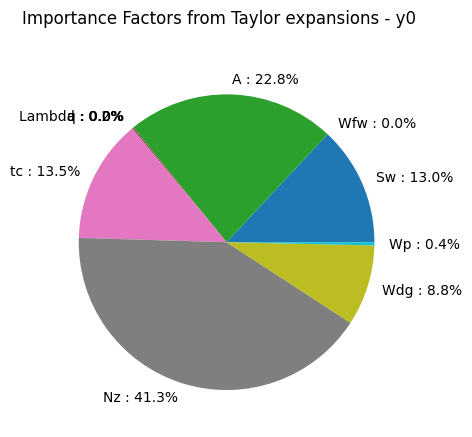

In [8]:
#facteurs d'importance
print(taylor.getImportanceFactors())
graph = taylor.drawImportanceFactors()
view = viewer.View(graph)

Composantes negligeables : Lambda, Wp, Wfw, q et l

q2= [0.999999]


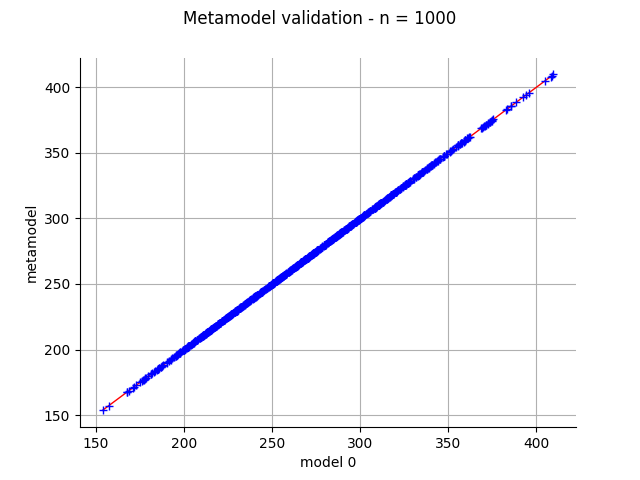

In [9]:
taille = 1000
x_test = ot.MonteCarloExperiment(distribution_entrees, taille).generate()
algo = ot.FunctionalChaosAlgorithm(echantillon_entree, echantillon_sortie, distribution_entrees)

algo.run()
result = algo.getResult()
N_approx = result.getMetaModel()
validation = ot.MetaModelValidation(x_test, model_masse(x_test), N_approx)
print("q2=", validation.computePredictivityFactor())
validation.drawValidation()

In [10]:
sensitivityAnalysis = ot.FunctionalChaosSobolIndices(result)
print(sensitivityAnalysis)

 input dimension: 10
 output dimension: 1
 basis size: 761
 mean: [268.075]
 std-dev: [48.0823]
------------------------------------------------------------
Index   | Multi-indice                  | Part of variance  
------------------------------------------------------------
      8 | [0,0,0,0,0,0,0,1,0,0]         | 0.410301
      3 | [0,0,1,0,0,0,0,0,0,0]         | 0.220094
      7 | [0,0,0,0,0,0,1,0,0,0]         | 0.138428
      1 | [1,0,0,0,0,0,0,0,0,0]         | 0.124464
      9 | [0,0,0,0,0,0,0,0,1,0]         | 0.0849162
------------------------------------------------------------


------------------------------------------------------------
Component | Sobol index            | Sobol total index      
------------------------------------------------------------
        0 | 0.124473               | 0.127899              
        1 | 2.83311e-06            | 2.9319e-06            
        2 | 0.220245               | 0.226014              
        3 | 0.000489344            | 0.

Les composantes négligeables (contribution inférieure à 0.5%) sont celles d'indice 1,3,4,5 et 9, à savoir Wfw, $\Lambda$, q, l et Wp.  
On obtient le même résultat qu'avec l'approximation de Taylor.

In [11]:
indices_negligeables = [1,3,4,5,9]
indices_influents = [0,2,6,7,8]
moyenne_entrees = np.array(moyenne_entrees)
model_masse_reduit = ot.ParametricFunction(model_masse, indices_negligeables, moyenne_entrees[indices_negligeables])

x_test_influent = x_test[:, indices_influents]

q2= [0.999999]


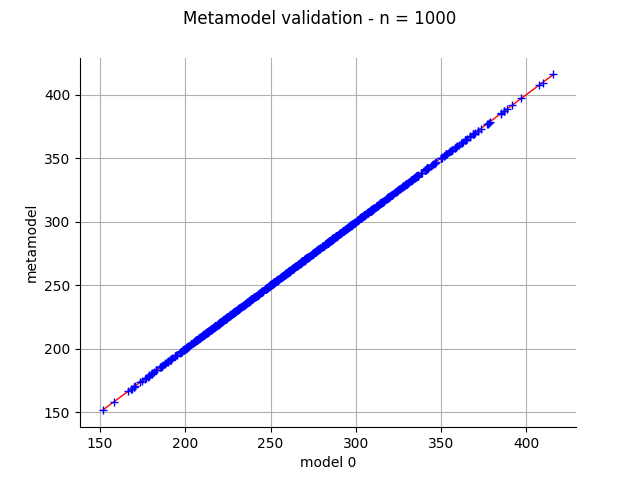

In [12]:
echantillon_sortie_reduit = model_masse_reduit(echantillon_entree[:,indices_influents])
distribution_entrees_reduit = ot.ComposedDistribution([ot.Uniform(150,200), ot.Uniform(6,10), ot.Uniform(0.08,0.18), ot.Uniform(2.5,6), ot.Uniform(1700,2500)])
algo = ot.FunctionalChaosAlgorithm(echantillon_entree[:,indices_influents], echantillon_sortie_reduit, distribution_entrees_reduit)

algo.run()
result = algo.getResult()
N_approx = result.getMetaModel()
validation = ot.MetaModelValidation(x_test_influent, model_masse_reduit(x_test_influent), N_approx)
print("q2=", validation.computePredictivityFactor())
validation.drawValidation()

## Analyse d'un évenement rare

In [13]:
Evenement = ot.ThresholdEvent(M, ot.GreaterOrEqual(), 460)
form = ot.FORM(ot.SQP(), Evenement, X.getMean())
nEval0 = model_masse.getCallsNumber()
form.run()
resultat_form = form.getResult()
P_form = resultat_form.getEventProbability()
nEval1 = model_masse.getCallsNumber()
print("Probabilité FORM=", P_form, "nb. evals=", nEval1 - nEval0)

Probabilité FORM= 0.0005096412044722048 nb. evals= 605
